<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<div style="text-align: center;">
<img src="../Imagenes/CUGDL_logo.png" alt="Drawing" style="width: 800px;"/>
</div>

<center> <span style="color:DarkBlue">  Tema 4. Regresi√≥n lineal: variables categ√≥ricas </span>  </center>
<center> <span style="color:Blue"> Profesor: M. en C. Iv√°n A. Toledano Ju√°rez </span>  </center>

# El tratamiento de las variables categ√≥ricas

Hasta ahora has trabajado con variables num√©ricas en modelos de regresi√≥n, pero en problemas reales es muy com√∫n encontrarse con informaci√≥n **categ√≥rica**: desde el tipo de dispositivo que usa un cliente, hasta su g√©nero, regi√≥n o preferencia de compra. En este notebook vas a aprender c√≥mo incluir ese tipo de variables en un modelo de **regresi√≥n lineal usando `scikit-learn`**, de manera eficiente.

Trabajaremos con un dataset simulado de comercio electr√≥nico llamado `ecom_simulated`, que representa situaciones cercanas a aplicaciones reales. Ver√°s c√≥mo convertir variables categ√≥ricas en datos que un modelo puede entender, entrenar√°s un modelo de regresi√≥n con ellas, y sobre todo, **aprender√°s a interpretar sus resultados en ese contexto**. Adem√°s, analizaremos c√≥mo cambian los coeficientes del modelo seg√∫n la codificaci√≥n, y qu√© significa que una categor√≠a quede como referencia.

Posteriormente, aplicaremos lo aprendido en otro notebook utilizando el dataset cl√°sico `mtcars`, donde exploraremos c√≥mo aplicar **transformaciones logar√≠tmicas** sobre variables num√©ricas para mejorar el ajuste del modelo y capturar relaciones que no son lineales a simple vista.

Este ejercicio no solo te permitir√° ampliar tu dominio de la regresi√≥n lineal, sino que tambi√©n te prepara para trabajar con conjuntos de datos m√°s diversos y realistas, como los que enfrentar√°s en proyectos o competencias de machine learning.

In [1]:
# Importaci√≥n de librer√≠as
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## Importaci√≥n de datos

In [2]:
mainpath = "../data/"
filename = "ecom_simulated/ecom.csv"
fullpath = os.path.join(mainpath,filename)

df_ecom = pd.read_csv(fullpath)

# Este dataframe tiene unos espacios innecesarios en las variables
df_ecom = df_ecom.rename(columns={"Age ": "Age", " Items ": "Items"})

df_ecom.head()

Transaction ID  Age  Items  Monthly Income  Transaction Time  Record  \
0         TXN001   42     10            7313        627.668127       5   
1         TXN002   24      8           17747        126.904567       3   
2         TXN003   47     11           22845        873.469701       2   
3         TXN004   50     11           18552        380.219428       7   
4         TXN005   60      2           14439        403.374223       2   

   Gender City Tier  Total Spend  
0  Female    Tier 1  4198.385084  
1  Female    Tier 2  4134.976648  
2    Male    Tier 2  5166.614455  
3  Female    Tier 1  7784.447676  
4  Female    Tier 2  3254.160485

In [3]:
df_ecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Transaction ID    2362 non-null   object 
 1   Age               2362 non-null   int64  
 2   Items             2362 non-null   int64  
 3   Monthly Income    2362 non-null   int64  
 4   Transaction Time  2362 non-null   float64
 5   Record            2362 non-null   int64  
 6   Gender            2362 non-null   object 
 7   City Tier         2362 non-null   object 
 8   Total Spend       2362 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 166.2+ KB


In [4]:
df_ecom.isna().any() # no hay valores nulos

Transaction ID      False
Age                 False
Items               False
Monthly Income      False
Transaction Time    False
Record              False
Gender              False
City Tier           False
Total Spend         False
dtype: bool

In [5]:
df_ecom.describe()

Age        Items  Monthly Income  Transaction Time  \
count  2362.000000  2362.000000     2362.000000       2362.000000   
mean     40.084674     7.884843    15962.884843        497.429603   
std      11.973412     4.283014     8046.517234        286.065147   
min      20.000000     1.000000     2003.000000          0.463297   
25%      30.000000     4.000000     9086.750000        253.443599   
50%      40.000000     8.000000    15764.000000        495.098046   
75%      51.000000    12.000000    23056.750000        745.833710   
max      60.000000    15.000000    30000.000000       1000.697201   

            Record   Total Spend  
count  2362.000000   2362.000000  
mean      4.928874   6163.176416  
std       3.084855   2799.772060  
min       0.000000   1099.815246  
25%       2.000000   3949.683101  
50%       5.000000   5602.193897  
75%       7.750000   8046.755618  
max      10.000000  13944.048160

Tenemos datos simulados de un sitio de e-commerce, que captura la informaci√≥n de varias transacciones realizadas en la plataforma.


* **Transaction ID**: Identificador de la transacci√≥n

* **Age**: Edad del cliente

* **Items**: n√∫mero de art√≠culos en el carrito (comprados)

* **Monthly Income**: cantidad monetaria mensual para gastos

* **Transaction time**: tiempo total que se estuvo en el website durante la transaccion

* **Record**: Cuantas veces el cliente ha comprado en el website en el pasado.

* **Gender**: g√©nero del cliente

* **City tier**: 

* **Total Spend**: cantidad monetaria total asociada a la transacci√≥n.

Tenemos datos de transacci√≥n, la edad del cliente, items que ha comprado, tiempo de transacci√≥n y g√©nero, el tipo de ciudad as√≠ como el gasto total. Registros financieros de un banco, y queremos predecir los gastos de un mes en particular basado en si vive en un barrio de buena clase o no, si es hombre o no.  Tanto el g√©nero como el city tier son variables categ√≥ricas.

## üéØ Codificando variables categ√≥ricas: dummy variables

Para que un modelo de regresi√≥n lineal pueda trabajar con variables categ√≥ricas como el `Gender` o el `City Tier`, necesitamos transformarlas en variables num√©ricas. Esto lo hacemos mediante **codificaci√≥n dummy**, que convierte cada categor√≠a en una nueva columna que toma el valor 1 si se cumple y 0 si no.

En este caso usamos `pandas.get_dummies()` con el argumento `drop_first=True`, lo que significa que **omitimos una de las categor√≠as como referencia**. Esto es importante porque evita que las variables codificadas est√©n perfectamente correlacionadas entre s√≠ (colinealidad perfecta), algo que podr√≠a afectar el modelo. La categor√≠a omitida se convierte en la base con la cual se comparan las dem√°s.

M√°s adelante, cuando interpretemos el modelo, podremos entender qu√© significa tener `Gender_Male = 1` o `City Tier_2 = 1`, siempre en comparaci√≥n con la categor√≠a que qued√≥ fuera.


In [6]:
## Creaci√≥n de las variables dummy con pandas

df_ecom= pd.get_dummies(df_ecom, columns=['Gender'], drop_first=True, dtype=int)
df_ecom= pd.get_dummies(df_ecom, columns=['City Tier'], drop_first=True, dtype=int)

# El argumento drop_first remueve la primer categor√≠a que se encuentra, para no tener informaci√≥n redundante

# Verificamos el resultado
display(df_ecom.head(5))

Transaction ID  Age  Items  Monthly Income  Transaction Time  Record  \
0         TXN001   42     10            7313        627.668127       5   
1         TXN002   24      8           17747        126.904567       3   
2         TXN003   47     11           22845        873.469701       2   
3         TXN004   50     11           18552        380.219428       7   
4         TXN005   60      2           14439        403.374223       2   

   Total Spend  Gender_Male  City Tier_Tier 2  City Tier_Tier 3  
0  4198.385084            0                 0                 0  
1  4134.976648            0                 1                 0  
2  5166.614455            1                 1                 0  
3  7784.447676            0                 0                 0  
4  3254.160485            0                 1                 0

Por ejemplo, en este caso, si la variable `Gender` se convierte en `Gender_Male`, su coeficiente en el modelo indicar√° c√≥mo cambia la variable respuesta cuando el g√©nero es masculino, **en comparaci√≥n con la categor√≠a omitida** (que ser√≠a `Female`, en este caso). Este paso es clave para poder incluir variables categ√≥ricas correctamente en un modelo lineal sin caer en problemas de colinealidad.

> ‚ö†Ô∏è **Importante:** cuando usamos `drop_first=True` para eliminar una de las categor√≠as de una variable categ√≥rica, es fundamental **prestar atenci√≥n a cu√°l categor√≠a se est√° eliminando**, ya que ser√° la que se utilice como **categor√≠a de referencia** en la interpretaci√≥n del modelo. Esta decisi√≥n afecta directamente el significado de los coeficientes.

Esto cobra especial importancia cuando una variable tiene **m√°s de dos categor√≠as** (por ejemplo, `City Tier` con valores `1`, `2` y `3`). En ese caso, una de ellas ser√° descartada autom√°ticamente, y todas las dem√°s se interpretar√°n en relaci√≥n con esa categor√≠a. Si no verificamos expl√≠citamente cu√°l fue removida, podr√≠amos malinterpretar los resultados o incluso cometer errores al comunicar las conclusiones del modelo.

Para evitar confusiones, es buena pr√°ctica **revisar con `df.dtypes` y `df.columns` el resultado de `get_dummies()`** y, si se desea mayor control, usar el argumento `categories` con `OneHotEncoder` o crear las dummies manualmente especificando el orden de referencia.

## Codificando variables categ√≥ricas con `OneHotEncoder`

Otra forma muy com√∫n y flexible de transformar variables categ√≥ricas para modelos de machine learning es usando `OneHotEncoder`, una herramienta incluida en `scikit-learn`. A diferencia de `pandas.get_dummies()`, que transforma directamente un `DataFrame`, `OneHotEncoder` es especialmente √∫til cuando trabajamos con **pipelines automatizados** o queremos integrar el preprocesamiento dentro del flujo completo de modelado.

Este codificador crea nuevas columnas binarias para cada categor√≠a de las variables seleccionadas, igual que `get_dummies()`, y tambi√©n permite eliminar una categor√≠a por variable con `drop='first'` para evitar colinealidad. Una ventaja adicional es que `OneHotEncoder` puede usarse junto con `ColumnTransformer`, lo que nos da un control m√°s fino para aplicar transformaciones diferentes a columnas num√©ricas y categ√≥ricas dentro del mismo pipeline.

En este notebook lo utilizaremos para transformar variables como `Gender` y `City Tier`, dejando nuestras variables listas para ser utilizadas en modelos de regresi√≥n lineal u otros algoritmos de aprendizaje autom√°tico.


In [7]:
df_ecom.columns

Index(['Transaction ID', 'Age', 'Items', 'Monthly Income', 'Transaction Time',
       'Record', 'Total Spend', 'Gender_Male', 'City Tier_Tier 2',
       'City Tier_Tier 3'],
      dtype='object')

In [8]:
## Con OneHotEncoder

# Carga de datos
filename = "ecom_simulated/ecom.csv"
fullpath = os.path.join(mainpath,filename)
df_ecom = pd.read_csv(fullpath)
df_ecom = df_ecom.rename(columns={"Age ": "Age", " Items ": "Items"})

# Seleccionamos las columnas categ√≥ricas y num√©ricas
categorical_cols = ['Gender', 'City Tier'] # omitimos variable 'Transaction ID', pues no aporta informaci√≥n
numerical_cols = ['Age', 'Items', 'Monthly Income', 'Transaction Time', 'Record', 'Total Spend']

# Creamos el dataframe que queremos codificar
# En este caso es el dataframe original pero sin la variable 'Transaction ID'
df_ecom = df_ecom[categorical_cols + numerical_cols]

# Instanciamos el codificador OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, dtype=int)

# Aplicamos la codificaci√≥n con ColumnTransformer
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', ohe, categorical_cols)
    ],
    remainder='passthrough'  # deja pasar las columnas num√©ricas sin cambios
)

# Aplicamos el transformador
X_encoded = column_transformer.fit_transform(df_ecom)

# Recuperamos los nombres de las columnas dummy codificadas
encoded_col_names = column_transformer.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combinamos nombres codificados y los que pasaron directamente
final_columns = list(encoded_col_names) + numerical_cols  # agregar nombres de las columnas que pasaron sin transformaci√≥n

# Convertimos a DataFrame para inspecci√≥n
df_ecom_encoded = pd.DataFrame(X_encoded, columns=final_columns)

# Mostramos las primeras filas
df_ecom_encoded.head()

Gender_Male  City Tier_Tier 2  City Tier_Tier 3   Age  Items  \
0          0.0               0.0               0.0  42.0   10.0   
1          0.0               1.0               0.0  24.0    8.0   
2          1.0               1.0               0.0  47.0   11.0   
3          0.0               0.0               0.0  50.0   11.0   
4          0.0               1.0               0.0  60.0    2.0   

   Monthly Income  Transaction Time  Record  Total Spend  
0          7313.0        627.668127     5.0  4198.385084  
1         17747.0        126.904567     3.0  4134.976648  
2         22845.0        873.469701     2.0  5166.614455  
3         18552.0        380.219428     7.0  7784.447676  
4         14439.0        403.374223     2.0  3254.160485

## Comparaci√≥n: `get_dummies()` vs `OneHotEncoder`

Al final, tanto `pandas.get_dummies()` como `OneHotEncoder` generan columnas similares: **variables binarias que representan a las categor√≠as**. La diferencia real **no est√° en el resultado**, sino en el **contexto de uso** en **c√≥mo se integran dentro flujos de machine learning m√°s complejos**. A continuaci√≥n se presenta una tabla comparativa.

| Aspecto                                             | `pandas.get_dummies()`                     | `OneHotEncoder` + `ColumnTransformer`         |
|-----------------------------------------------------|--------------------------------------------|-----------------------------------------------|
| Funciona directamente con `DataFrame`               | ‚úÖ S√≠                                       | ‚ùå No (trabaja sobre arrays)                   |
| F√°cil de usar para exploraci√≥n r√°pida               | ‚úÖ Muy c√≥modo                               | ‚ùå Requiere pasos adicionales                 |
| Compatible con `Pipeline` de `scikit-learn`         | ‚ùå No se integra autom√°ticamente            | ‚úÖ S√≠, totalmente compatible                   |
| Permite reutilizar (`fit`/`transform`)              | ‚ùå No                                       | ‚úÖ S√≠                                          |
| Evita fugas de datos en validaci√≥n cruzada          | ‚ùå Se requiere cuidado manual               | ‚úÖ Integraci√≥n autom√°tica en validaci√≥n        |
| Consistencia entre entrenamiento y prueba           | ‚ùå Hay que codificar manualmente            | ‚úÖ Se garantiza dentro del pipeline            |
| Control preciso de columnas a transformar           | ‚úÖ Parcial (con `columns=`)                | ‚úÖ Total con `ColumnTransformer`              |
| Ideal para notebooks y an√°lisis exploratorios       | ‚úÖ S√≠                                       | ‚ùå No necesariamente                           |
| Ideal para producci√≥n, despliegue y automatizaci√≥n  | ‚ùå No                                       | ‚úÖ S√≠                                          |

* Usa `get_dummies()` si est√°s:
    * Explorando los datos de forma r√°pida o visual
    * Trabajando en un notebook demostrativo
    * Necesitas algo simple y directo
* Usa `OneHotEncoder` si:
    * Estas construyendo un **pipeline completo de machine learning**
    * Quieres juntar en un pipeline una validaci√≥n cruzada, o b√∫squeda de hiperpar√°metros
    * Vas a exportar el modelo para producci√≥n o reutilizarlo
    * Quiero que todo el procesamiento est√© integrado en el modelo

## Entrenamiento del modelo de regresi√≥n lineal

Una vez que nuestras variables categ√≥ricas han sido transformadas en variables num√©ricas mediante codificaci√≥n dummy, ya podemos entrenar un modelo de **regresi√≥n lineal** utilizando `scikit-learn`. En este caso, el modelo se encargar√° de aprender c√≥mo las diferentes variables ‚Äîtanto num√©ricas como categ√≥ricas codificadas‚Äî se relacionan con la variable objetivo (por ejemplo, el monto de compra).

El proceso es el mismo que en modelos anteriores: seleccionamos las columnas predictoras (`X`), definimos la variable respuesta (`y`), instanciamos el modelo con `LinearRegression()`, lo entrenamos con `.fit()`, y evaluamos su rendimiento usando m√©tricas como $$R^2$$, el error cuadr√°tico medio (MSE) y su ra√≠z cuadrada (RMSE). Este modelo ya est√° listo para hacer predicciones y comenzar a interpretarse.


In [9]:
# Hacemos una lista de las variables predictoras que queremos incluir
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3"]

In [10]:
# Matriz de caracter√≠sticas X, y la variable objetivo y
X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

In [11]:
lm = LinearRegression() # instanciamos el modelo, y sus par√°metros
model = lm.fit(X,y) # entrenamos el modelo

In [12]:
# Imprimimos sus par√°metros de ajuste
print('√ü0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('√ü'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

√ü0:  3681.235
√ü1:  0.153 asociado a variable Monthly Income
√ü2:  0.124 asociado a variable Transaction Time
√ü3:  188.316 asociado a variable Gender_Male
√ü4:  -136.342 asociado a variable City Tier_Tier 2
√ü5:  -222.647 asociado a variable City Tier_Tier 3


In [13]:
# Si queremos, incluso podemos juntar estos valores en una lista
list(zip(feature_cols,lm.coef_))

[('Monthly Income', np.float64(0.15297824609320482)),
 ('Transaction Time', np.float64(0.12372608642590247)),
 ('Gender_Male', np.float64(188.31559766064015)),
 ('City Tier_Tier 2', np.float64(-136.3422696118916)),
 ('City Tier_Tier 3', np.float64(-222.64748519981194))]

De esta forma, el modelo lineal propuesto ser√≠a el siguiente:

\begin{equation}
\rm{Total \ Spend} = 3681.235 + 0.153 \ \rm{Monthly \ Income} + 0.124 \ \rm{Transaction \ Time} + 188.316 \ \rm{Gender\_Male} - 136.342\rm \ {City \ Tier\_Tier \ 2} - 222.647 \ \rm{City \ Tier\_Tier \ 3}
\end{equation}

In [14]:
lm.score(X,y)
# es un r2 bajo y probablemente es porque no hemos utilizado todas las variables
# necesitamos mas informacion

0.19478920552885381

Agregamos la variable record

In [15]:
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3", 'Record']

In [16]:
X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

In [17]:
lm = LinearRegression() # crea el modelo y luego ponemos sus parametros
lm.fit(X,y)

LinearRegression()

In [18]:
print('√ü0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('√ü'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

√ü0:  -133.678
√ü1:  0.148 asociado a variable Monthly Income
√ü2:  0.155 asociado a variable Transaction Time
√ü3:  262.05 asociado a variable Gender_Male
√ü4:  -21.625 asociado a variable City Tier_Tier 2
√ü5:  -208.668 asociado a variable City Tier_Tier 3
√ü6:  772.233 asociado a variable Record


In [19]:
list(zip(feature_cols,lm.coef_))

[('Monthly Income', np.float64(0.14753898049205752)),
 ('Transaction Time', np.float64(0.15494612549589526)),
 ('Gender_Male', np.float64(262.05002651109584)),
 ('City Tier_Tier 2', np.float64(-21.62535170126283)),
 ('City Tier_Tier 3', np.float64(-208.66762633022265)),
 ('Record', np.float64(772.2334457445638))]

In [20]:
lm.score(X,y)
# tenemos un r2 mucho mejor

0.9179923586131016

Podemos seguir y agregar la variable edad

In [21]:
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3", 'Record', 'Age']

X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

lm = LinearRegression()
lm.fit(X,y)

print('√ü0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('√ü'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

print('R2: ', lm.score(X,y))


√ü0:  -390.448
√ü1:  0.147 asociado a variable Monthly Income
√ü2:  0.156 asociado a variable Transaction Time
√ü3:  266.177 asociado a variable Gender_Male
√ü4:  -26.353 asociado a variable City Tier_Tier 2
√ü5:  -208.783 asociado a variable City Tier_Tier 3
√ü6:  772.149 asociado a variable Record
√ü7:  6.424 asociado a variable Age
R2:  0.9187458997709432


El coeficiente de determinaci√≥n $R^2$ no creci√≥ mucho al incluir la variable `Age`. Esto podr√≠a ser un indicativo de que esta variable no es un buen indicador en nuestro modelo. Aunque, estrictamente hablando, es necesario explorar todas las variables posibles. Nos quedamos con el modelo hasta `Record`

In [22]:
feature_cols = ["Monthly Income", "Transaction Time", "Gender_Male", "City Tier_Tier 2", "City Tier_Tier 3", 'Record']

X = df_ecom_encoded[feature_cols]
y = df_ecom_encoded["Total Spend"]

lm = LinearRegression()
lm.fit(X,y)

print('√ü0: ', round(lm.intercept_,3))
for i in range(0, len(lm.coef_)):
    print('√ü'+str(i+1)+': ', round(lm.coef_[i],3), 'asociado a variable', lm.feature_names_in_[i])

print('R2: ', lm.score(X,y))


√ü0:  -133.678
√ü1:  0.148 asociado a variable Monthly Income
√ü2:  0.155 asociado a variable Transaction Time
√ü3:  262.05 asociado a variable Gender_Male
√ü4:  -21.625 asociado a variable City Tier_Tier 2
√ü5:  -208.668 asociado a variable City Tier_Tier 3
√ü6:  772.233 asociado a variable Record
R2:  0.9179923586131016


El modelo ser√≠a el siguiente:

\begin{equation}
\rm{Total \ Spend} = -133.678 + 0.148 \ \rm{Monthly \ Income} + 0.155 \ \rm{Transaction \ Time} + 262.05 \ \rm{Gender\_Male} - 21.625\rm \ {City \ Tier\_Tier \ 2} - 208.668 \ \rm{City \ Tier\_Tier \ 3} + 772.233 \ \rm{Record}
\end{equation}

Ya con el modelo, ahora podemos pasar a la evaluaci√≥n. Podemos agregar una columna de predicciones al dataframe original.

In [23]:
df_ecom_encoded['prediction'] = lm.predict(X)

In [24]:
df_ecom_encoded.head()

Gender_Male  City Tier_Tier 2  City Tier_Tier 3   Age  Items  \
0          0.0               0.0               0.0  42.0   10.0   
1          0.0               1.0               0.0  24.0    8.0   
2          1.0               1.0               0.0  47.0   11.0   
3          0.0               0.0               0.0  50.0   11.0   
4          0.0               1.0               0.0  60.0    2.0   

   Monthly Income  Transaction Time  Record  Total Spend   prediction  
0          7313.0        627.668127     5.0  4198.385084  4903.696720  
1         17747.0        126.904567     3.0  4134.976648  4799.434826  
2         22845.0        873.469701     2.0  5166.614455  5157.082504  
3         18552.0        380.219428     7.0  7784.447676  8068.012996  
4         14439.0        403.374223     2.0  3254.160485  3581.980335

SSD:  1517733985.340816
RSE:  802.7907758991204
RSE porcentual:  0.13 %


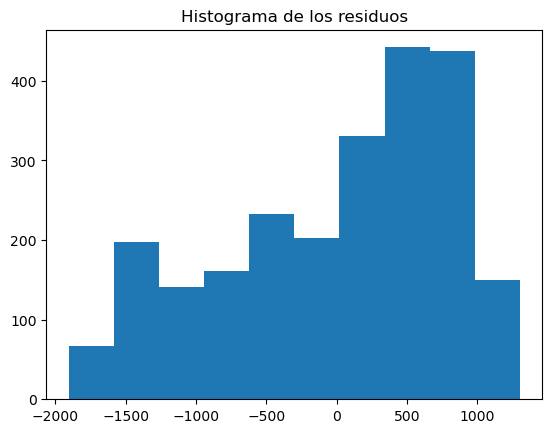

In [25]:
# An√°lisis de los residuos
SSD = np.sum((df_ecom_encoded["prediction"] - df_ecom_encoded["Total Spend"])**2)
print('SSD: ', SSD)

RSE = np.sqrt(SSD/(len(df_ecom_encoded)-len(feature_cols)-1)) # recordar que tenemos un numero de len(feature_cols) de variables predictoras
print('RSE: ', RSE)

sales_mean = np.mean(df_ecom_encoded["Total Spend"])
error = RSE/sales_mean
print('RSE porcentual: ', round(error,2), '%')

# plot de residuos
plt.hist(df_ecom_encoded['prediction'] - df_ecom_encoded['Total Spend'])
plt.title('Histograma de los residuos')
plt.show()

El RSE porcentual no es muy alto ($\sim$ 13%), aunque los residuos parecen no ser tan normales. A√∫n queda un poco de mejor√≠a pero no mucho m√°s.

## üîÅ Transformaci√≥n de variables: m√°s all√° de lo lineal

Hasta ahora hemos asumido que la relaci√≥n entre las variables predictoras y la variable objetivo es aproximadamente lineal. Sin embargo, en muchos casos reales esto no se cumple tan f√°cilmente. Algunas variables pueden estar **sesgadas**, tener **valores extremos**, o simplemente mostrar una relaci√≥n no lineal con la respuesta. Si aplicamos una regresi√≥n lineal sobre estos datos sin hacer ajustes, el modelo puede tener un mal desempe√±o y generar conclusiones enga√±osas.

Aqu√≠ es donde entran las **transformaciones de variables**. Aplicar funciones como el logaritmo, la ra√≠z cuadrada o incluso otras m√°s avanzadas puede ayudarnos a:
- Linealizar relaciones que no lo son.
- Estabilizar la varianza (reducir heterocedasticidad).
- Mitigar el efecto de valores at√≠picos o colas largas.

En esta secci√≥n exploraremos c√≥mo aplicar transformaciones sobre variables num√©ricas usando el dataset cl√°sico `mtcars`, y veremos c√≥mo estas transformaciones pueden mejorar la interpretaci√≥n y el ajuste del modelo. En este dataset, normalmente la variable objetivo es `mpg`, el rendimiento del auto.

In [26]:
filename = "mtcars/mtcars.csv"
fullpath = os.path.join(mainpath,filename)

df_mtcars = pd.read_csv(fullpath)
df_mtcars.head()

model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

   carb  
0     4  
1     4  
2     1  
3     1  
4     2

Antes de aplicar cualquier transformaci√≥n, es importante observar c√≥mo se comporta la variable que queremos usar como predictor. En este caso, vamos a explorar la variable `hp` (caballos de fuerza) y c√≥mo se relaciona con el consumo de combustible `mpg`. Esto nos permitir√° identificar si la distribuci√≥n est√° sesgada o si la relaci√≥n con la variable objetivo parece no lineal.

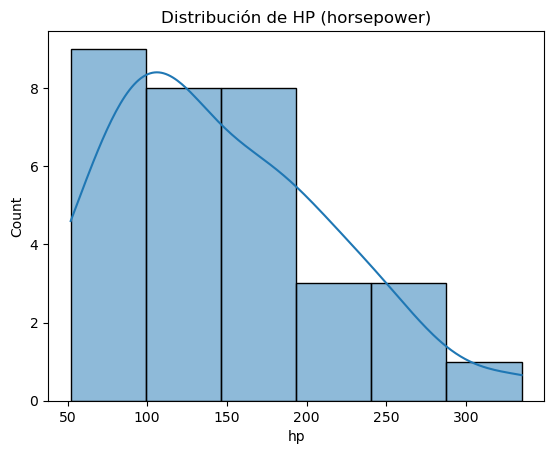

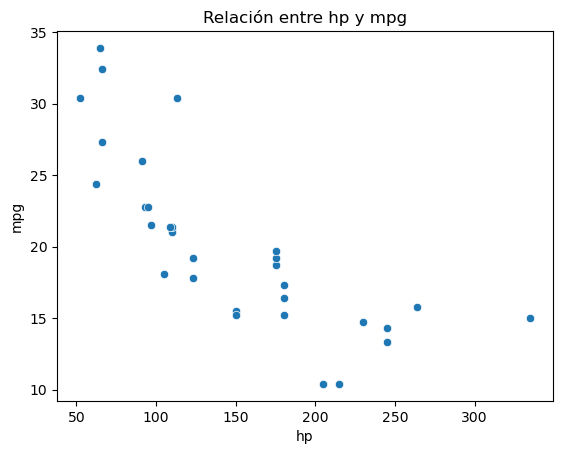

In [27]:
# Visualizaci√≥n de la variable original
sns.histplot(df_mtcars['hp'], kde=True)
plt.title("Distribuci√≥n de HP (horsepower)")
plt.xlabel("hp")
plt.show()

# Dispersi√≥n con mpg (consumo)
sns.scatterplot(x='hp', y='mpg', data=df_mtcars)
plt.title("Relaci√≥n entre hp y mpg")
plt.xlabel("hp")
plt.ylabel("mpg")
plt.show()

## Aplicando una transformaci√≥n logar√≠tmica

Una de las transformaciones m√°s comunes cuando las variables est√°n sesgadas o presentan relaciones no lineales es la transformaci√≥n logar√≠tmica. Al aplicar `log(hp)`, buscamos linealizar la relaci√≥n con `mpg` y mejorar la estabilidad del modelo. A continuaci√≥n, observamos c√≥mo cambia la distribuci√≥n y la relaci√≥n con la variable objetivo.


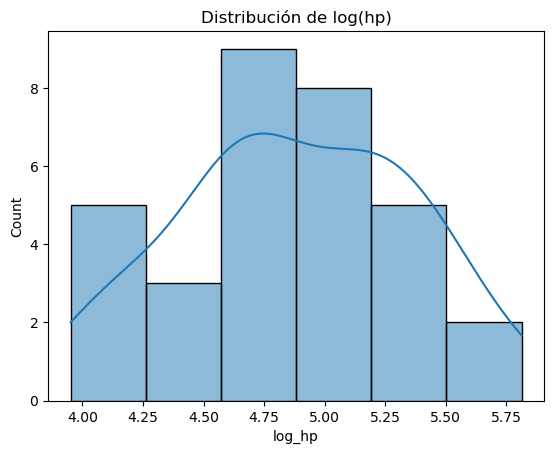

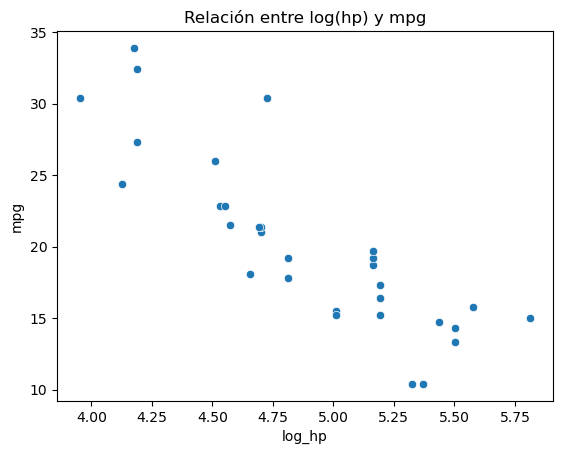

In [28]:
# A√±adir columna transformada
df_mtcars['log_hp'] = np.log(df_mtcars['hp'])

# Histograma de la variable transformada
sns.histplot(df_mtcars['log_hp'], kde=True)
plt.title("Distribuci√≥n de log(hp)")
plt.xlabel("log_hp")
plt.show()

# Dispersi√≥n con mpg
sns.scatterplot(x='log_hp', y='mpg', data=df_mtcars)
plt.title("Relaci√≥n entre log(hp) y mpg")
plt.xlabel("log_hp")
plt.ylabel("mpg")
plt.show()

## Entrenamiento del modelo con la variable transformada

Con la variable `log_hp` ya lista, podemos entrenar un modelo de regresi√≥n lineal para predecir `mpg`. Compararemos el rendimiento de este nuevo modelo con el anterior (sin transformaci√≥n) para ver si hemos logrado un mejor ajuste.


√ü0:  30.099
√ü1:  -0.068 asociado a variable hp
R¬≤: 0.602437341423934
MSE: 13.989822298268805


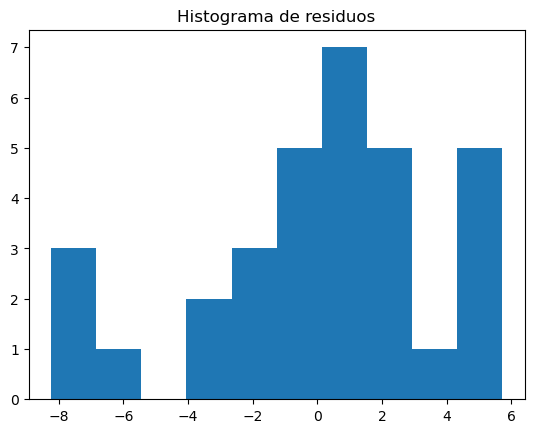

In [29]:
X = df_mtcars[['hp']]
y = df_mtcars['mpg']

model = LinearRegression()
model.fit(X, y)

print('√ü0: ', round(model.intercept_,3))
for i in range(0, len(model.coef_)):
    print('√ü'+str(i+1)+': ', round(model.coef_[i],3), 'asociado a variable', model.feature_names_in_[i])

y_pred = model.predict(X)

print("R¬≤:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))

# plot de residuos
plt.hist(y_pred - y)
plt.title('Histograma de residuos')
plt.show()

√ü0:  72.64
√ü1:  -10.764 asociado a variable log_hp
R¬≤: 0.7204117736506155
MSE: 9.83842299808868


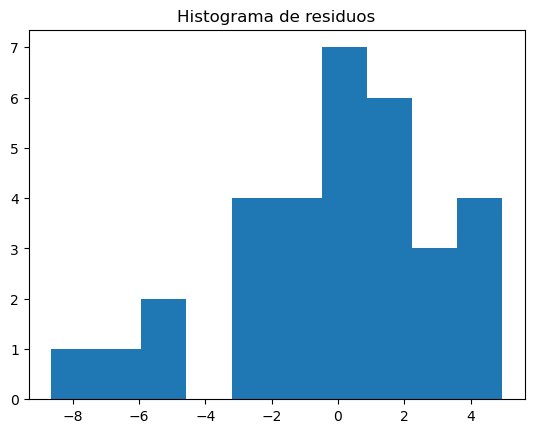

In [30]:
X = df_mtcars[['log_hp']]
y = df_mtcars['mpg']

model = LinearRegression()
model.fit(X, y)

print('√ü0: ', round(model.intercept_,3))
for i in range(0, len(model.coef_)):
    print('√ü'+str(i+1)+': ', round(model.coef_[i],3), 'asociado a variable', model.feature_names_in_[i])

y_pred = model.predict(X)

print("R¬≤:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))

# plot de residuos
plt.hist(y_pred - y)
plt.title('Histograma de residuos')
plt.show()

## Conclusi√≥n: ¬øvali√≥ la pena transformar?

Este peque√±o experimento nos muestra c√≥mo una transformaci√≥n adecuada puede mejorar tanto la interpretaci√≥n como el desempe√±o de un modelo de regresi√≥n lineal. Aunque no siempre ser√° necesaria, conocer y aplicar estas t√©cnicas puede marcar una gran diferencia en modelos del mundo real.

## Transformaciones logar√≠tmicas en modelos lineales

En regresi√≥n lineal, el uso de transformaciones logar√≠tmicas puede cambiar tanto la **forma matem√°tica del modelo** como la **interpretaci√≥n de los coeficientes**. A continuaci√≥n se presenta una tabla con los cuatro casos m√°s comunes:

| Modelo                             | Ecuaci√≥n                                                   | Interpretaci√≥n del coeficiente $\beta_1$                              |
|------------------------------------|-------------------------------------------------------------|------------------------------------------------------------------------|
| **Lineal-Lineal**                 | $\begin{equation} y = \beta_0 + \beta_1 x + \varepsilon \end{equation}$        | Un cambio de una unidad en $x$ produce un cambio de $\beta_1$ unidades en $y$. |
| **Lineal-Log**                    | $\begin{equation} y = \beta_0 + \beta_1 \log(x) + \varepsilon \end{equation}$  | Un cambio del 1% en $x$ se asocia con un cambio aproximado de $\beta_1/100$ en $y$. |
| **Log-Lineal**                    | $\begin{equation} \log(y) = \beta_0 + \beta_1 x + \varepsilon \end{equation}$  | Un cambio de una unidad en $x$ se asocia con un cambio de $100 \cdot \beta_1\%$ en $y$. |
| **Log-Log**                       | $\begin{equation} \log(y) = \beta_0 + \beta_1 \log(x) + \varepsilon \end{equation}$ | Un cambio del 1% en $x$ se asocia con un cambio de aproximadamente $\beta_1\%$ en $y$. |

> üí° En todos los casos, $\varepsilon$ representa el error aleatorio. Las transformaciones logar√≠tmicas son especialmente √∫tiles cuando las variables tienen distribuciones sesgadas o relaciones no lineales.

Para terminar, en nuestro caso particular, nuestro modelo quedar√≠a de la siguiente forma:

\begin{equation}
\rm{mpg} = 72.64 - 10.764 \ \log(\rm{hp})
\end{equation}

---

## Resumen

- Aprendimos a incorporar variables categ√≥ricas a un modelo de regresi√≥n lineal utilizando codificaci√≥n dummy.
- Discutimos la importancia de saber cu√°l categor√≠a se toma como referencia al eliminar una columna para evitar colinealidad.
- Exploramos transformaciones logar√≠tmicas de variables num√©ricas para mejorar la linealidad y estabilizar la varianza.
- Analizamos los diferentes modelos lineales (lineal-lineal, log-lineal, etc.) y sus interpretaciones.
- Finalmente, reafirmamos que construir un buen modelo requiere tanto conocimiento t√©cnico como criterio anal√≠tico.

---

## Conclusi√≥n

A lo largo de este notebook exploramos c√≥mo construir modelos de regresi√≥n lineal cuando trabajamos con **variables categ√≥ricas** y c√≥mo **transformar variables num√©ricas** para mejorar la calidad del ajuste. Aprendimos a codificar variables cualitativas con `get_dummies()` y tambi√©n conocimos una alternativa m√°s flexible con `OneHotEncoder`. Posteriormente, analizamos c√≥mo las **transformaciones logar√≠tmicas** pueden ser una herramienta poderosa para corregir sesgos, linealizar relaciones y mejorar la interpretaci√≥n del modelo. Adem√°s, destacamos c√≥mo la correcta elecci√≥n y tratamiento de variables puede tener un impacto significativo en el desempe√±o del modelo.

Este tipo de an√°lisis nos recuerda que el trabajo con modelos no se trata solo de aplicar herramientas autom√°ticamente, sino de **entender los datos, cuestionar sus propiedades y tomar decisiones fundamentadas**. Cada transformaci√≥n o codificaci√≥n que hacemos cambia el sentido del modelo, y por eso es tan importante tener una mirada cr√≠tica y consciente.


